<a href="https://colab.research.google.com/github/brendanpshea/database_sql/blob/main/Database_07_Views.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Musical "VIEW" For Better Data Presentation
### Database and SQL Through Pop Culture | Brendan Shea, PhD

In the world of database management, presenting and manipulating data efficiently and securely is paramount. SQLite, a lightweight yet powerful relational database management system, offers two invaluable tools for achieving these goals: Views and Common Table Expressions (CTEs).

Views are virtual tables that encapsulate complex queries, allowing you to present data in a simplified, reusable manner. They provide a way to aggregate information, control access to sensitive data, and create user-friendly interfaces for querying. CTEs, on the other hand, are temporary named result sets within a single SQL statement. They enable you to break down intricate queries into manageable parts, making your code more readable and maintainable.

In this chapter, we will dive deep into the concepts of Views and CTEs in SQLite. Using a real-world dataset related to music, sourced from Rollingstone and Spotify, we will explore practical examples and step-by-step explanations. You will learn how to create and utilize Views and CTEs effectively to present, aggregate, and secure your data.

Whether you are a novice or an experienced SQLite user, mastering Views and CTEs is essential for developing efficient and sustainable database solutions. By the end of this chapter, you will have a firm grasp of these concepts and be equipped to apply them in your own projects. Let's embark on this journey to unlock the full potential of Views and CTEs in SQLite!

Learning Outcomes:

1.  Understand the concept and benefits of Views in SQLite
2.  Learn how to create and query Views for presenting and aggregating data
3.  Explore the use of Views for securing sensitive data
4.  Discover the different types of Views and their use cases
5.  Understand Common Table Expressions (CTEs) and their syntax
6.  Learn how to use CTEs to simplify complex queries and improve code readability
7.  Explore real-world examples and case studies of using Views and CTEs in a music ranking web app
8.  Gain insights into data governance, data loss prevention, and compliance with global regulations like GDPR

Keywords: SQLite, Views, Common Table Expressions, CTEs, Data Presentation, Data Aggregation, Data Security, Data Governance, GDPR

## Brendan's Lecture

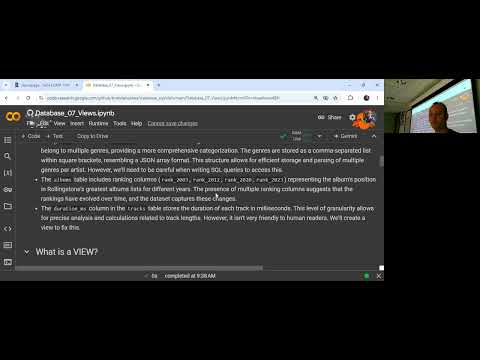

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('UYlAo8F9wco', width=800, height=500)

In [4]:
!wget https://github.com/brendanpshea/database_sql/raw/main/data/rs_greatest_albums.db -q -nc
!pip install prettytable==0.7.2 --force-reinstall -q

import pandas as pd

# Load sql magic and connect
%reload_ext sql
%config SqlMagic.autopandas=True
pd.set_option('display.max_colwidth', 150)

%sql sqlite:///rs_greatest_albums.db

## Data Dictionary for "Rolling Stone's Greatest Albums DB."
Before diving into views, it is good to get familiar with our data. Here's the **data dictionary** for our database. (Brendan's Note: I created this database manually, using Rollingstone's lists as a starting point, and then getting the other data from Spotify **Application Programming Interface (API)**.

#### **Table: `artists`**

This table contains information about the artists included in the RollingStone's greatest albums lists.

| **Column Name** | **Data Type** | **Description** |
| --- | --- | --- |
| `artist_id` | STRING | Unique identifier for each artist. |
| `Artist` | TEXT | Name of the artist. |
| `followers` | INTEGER | Number of followers the artist has on Spotify. |
| `genres` | TEXT | Comma-separated list of genres associated with the artist. |
| `popularity` | INTEGER | Popularity score of the artist on Spotify, ranging from 0 to 100. |

#### **Table: `albums`**

This table contains information about the albums listed in RollingStone's greatest albums lists of various years.

| **Column Name** | **Data Type** | **Description** |
| --- | --- | --- |
| `album_id` | STRING | Unique identifier for each album. |
| `Album` | TEXT | Title of the album. |
| `artist_id` | STRING | Unique identifier for the artist who created the album. |
| `Year` | INTEGER | Year the album was released. |
| `rank_2003` | INTEGER | Ranking of the album in RollingStone's 2003 list. |
| `rank_2012` | INTEGER | Ranking of the album in RollingStone's 2012 list. |
| `rank_2020` | INTEGER | Ranking of the album in RollingStone's 2020 list. |
| `rank_2023` | INTEGER | Ranking of the album in RollingStone's 2023 list. |
| **Foreign Key** |  | **FOREIGN KEY (`artist_id`) REFERENCES `artists`(`artist_id`)** |

#### **Table: `tracks`**

This table contains information about the tracks within the albums listed in the database.

| **Column Name** | **Data Type** | **Description** |
| --- | --- | --- |
| `track_id` | STRING | Unique identifier for each track. |
| `track_name` | TEXT | Name of the track. |
| `album_id` | STRING | Unique identifier for the album that the track belongs to. |
| `track_number` | INTEGER | The position of the track within the album. |
| `duration_ms` | INTEGER | Duration of the track in milliseconds. |
| **Foreign Key** |  | **FOREIGN KEY (`album_id`) REFERENCES `albums`(`album_id`)** |

### Examining the "Head" of the Data
Before trying to design our own queries, let's take a look at the **head** of the data (that is, the first few rows). We can do this using LIMIT.

In [5]:
%%sql
SELECT * FROM artists LIMIT 5;

 * sqlite:///rs_greatest_albums.db
Done.


,artist_id,Artist,followers,genres,popularity
0,3koiLjNrgRTNbOwViDipeA,"Gaye, Marvin",5313182,"['classic soul', 'motown', 'neo soul', 'northern soul', 'quiet storm', 'soul']",71
1,3oDbviiivRWhXwIE8hxkVV,Beach Boys,4499081,"['baroque pop', 'classic rock', 'folk rock', 'mellow gold', 'psychedelic rock', 'rock', 'singer-songwriter', 'sunshine pop']",71
2,5hW4L92KnC6dX9t7tYM4Ve,"Mitchell, Joni",1461857,"['canadian singer-songwriter', 'folk', 'folk rock', 'singer-songwriter']",59
3,7guDJrEfX3qb6FEbdPA5qi,"Wonder, Stevie",6427524,"['motown', 'soul']",73
4,3WrFJ7ztbogyGnTHbHJFl2,Beatles,27469908,"['british invasion', 'classic rock', 'merseybeat', 'psychedelic rock', 'rock']",82


In [6]:
%%sql
SELECT * FROM albums LIMIT 5;

 * sqlite:///rs_greatest_albums.db
Done.


,album_id,Album,artist_id,Year,rank_2003,rank_2012,rank_2020,rank_2023
0,7qD9oSiS3xFJsw2oSV2akp,What's Going On,3koiLjNrgRTNbOwViDipeA,1971,6,6,1,1
1,2CNEkSE8TADXRT2AzcEt1b,Pet Sounds,3oDbviiivRWhXwIE8hxkVV,1966,2,2,2,2
2,1vz94WpXDVYIEGja8cjFNa,Blue,5hW4L92KnC6dX9t7tYM4Ve,1971,30,30,3,3
3,6YUCc2RiXcEKS9ibuZxjt0,Songs in the Key of Life,7guDJrEfX3qb6FEbdPA5qi,1976,57,57,4,4
4,0ETFjACtuP2ADo6LFhL6HN,Abbey Road,3WrFJ7ztbogyGnTHbHJFl2,1969,14,14,5,5


In [7]:
%%sql
SELECT * FROM tracks LIMIT 5;

 * sqlite:///rs_greatest_albums.db
Done.


,track_id,track_name,album_id,track_number,duration_ms
0,4cgLt753cDfsBAbpOcGnZi,What's Going On - Detroit Mix,7qD9oSiS3xFJsw2oSV2akp,1,247840
1,0lz97gXzH4DD822L62kLeK,What's Happening Brother - Detroit Mix,7qD9oSiS3xFJsw2oSV2akp,2,163146
2,0oQV9CKXruLbVUTn76eBnr,Flyin' High (In The Friendly Sky) - Detroit Mix,7qD9oSiS3xFJsw2oSV2akp,3,228693
3,3KAbXV1OSwthoke6BqR0y5,Save The Children - Detroit Mix,7qD9oSiS3xFJsw2oSV2akp,4,241626
4,1J3WjiLbPAdW0mSBTxoHQF,God Is Love - Detroit Mix,7qD9oSiS3xFJsw2oSV2akp,5,106733


You might notice a few things from this:

-   The primary keys (`artist_id`, `album_id`, `track_id`) are strings rather than the more commonly used integers. Spotify likely uses string identifiers because they are **globally unique identifiers (GUIDs)** and can be generated independently across different systems or databases without the need for coordination or central allocation. This allows for better scalability and distributed data management. These sorts of keys are common in **distributed databases** that live on multiple computers, and have large numbers of concurrent users.
-   The `genres` column in the `artists` table contains a list of genres associated with each artist. This indicates that an artist can belong to multiple genres, providing a more comprehensive categorization. The genres are stored as a comma-separated list within square brackets, resembling a JSON array format. This structure allows for efficient storage and parsing of multiple genres per artist. However, we'll need to be careful when writing SQL queries to access this.
-  The `albums` table includes ranking columns (`rank_2003`, `rank_2012`, `rank_2020`, `rank_2023`) representing the album's position in Rollingstone's greatest albums lists for different years. The presence of multiple ranking columns suggests that the rankings have evolved over time, and the dataset captures these changes.
- The `duration_ms` column in the `tracks` table stores the duration of each track in milliseconds. This level of granularity allows for precise analysis and calculations related to track lengths. However, it isn't very friendly to human readers. We'll create a view to fix this.

## What is a VIEW?

In SQL, a **view** is a virtual table that is based on the result of a SELECT statement. It acts as a stored query that can be accessed and manipulated as if it were a regular table. Views provide a way to simplify complex queries, present data in a more readable format, and enhance data security by limiting access to specific columns or rows.

The general syntax for creating a view in SQ is as follows:

```sql
CREATE [TEMP | TEMPORARY] VIEW [IF NOT EXISTS] view_name AS
SELECT column1, column2, ...
FROM table_name
WHERE condition;
```

Let's break down the components of the CREATE VIEW statement:

-   `TEMP` or `TEMPORARY`: These keywords are optional and are used to create a temporary view that exists only for the duration of the current session.
-   `IF NOT EXISTS`: This clause is optional and prevents an error from occurring if a view with the same name already exists.
-   `view_name`: This is the name you assign to the view. It follows the same naming conventions as tables.
-   `AS`: This keyword precedes the SELECT statement that defines the view.
-   `SELECT`: This is the query that retrieves the data for the view. It can include columns from one or more tables, along with any desired conditions, joins, or aggregations.

Once a view is created, you can query it just like you would query a regular table. The view's result set is dynamically generated each time it is accessed, based on the underlying SELECT statement.

Here's a simple example of creating a view:

In [8]:
%%sql
DROP VIEW IF EXISTS artist_info;

CREATE VIEW album_info AS
SELECT
  Albums.album,
  Albums.year,
  Artist.artist
FROM Albums
  JOIN Artists ON Albums.artist_id = Artists.artist_id;

 * sqlite:///rs_greatest_albums.db
Done.
(sqlite3.OperationalError) table album_info already exists
[SQL: CREATE VIEW album_info AS
SELECT
  Albums.album,
  Albums.year,
  Artist.artist
FROM Albums
  JOIN Artists ON Albums.artist_id = Artists.artist_id;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In this example, we create a view named `album_info` that combines information from the `albums` and `artists` tables. The view includes the `Album` and `Year` columns from the `albums` table and the `Artist` column from the `artists` table. The tables are joined based on the `artist_id` foreign key relationship.

Now, whenever we query the `album_info` view, it will return the result set as defined by the SELECT statement, providing a convenient way to access the combined album and artist information.

In [9]:
%%sql
SELECT * FROM album_info LIMIT 5;

 * sqlite:///rs_greatest_albums.db
Done.


,Album,Year,Artist
0,What's Going On,1971,"Gaye, Marvin"
1,Pet Sounds,1966,Beach Boys
2,Blue,1971,"Mitchell, Joni"
3,Songs in the Key of Life,1976,"Wonder, Stevie"
4,Abbey Road,1969,Beatles


Views offer several benefits, such as:

-   Simplifying complex queries by encapsulating them into a reusable entity.
-   Providing a layer of abstraction and hiding the complexity of the underlying tables.
-   Enhancing data security by restricting access to specific columns or rows.
-   Enabling consistent and centralized data access across multiple queries or applications.

In the following sections, we will explore various practical examples of using views in SQLite to present, aggregate, and secure data from the music dataset.

## Views for Presenting Data

Views provide a powerful way to present data in a more user-friendly and meaningful manner. By creating views, you can customize the appearance of the data, combine information from multiple tables, and present it in a way that is easier to understand and interpret. Let's look at a few examples using the music dataset.

### Greatest albums, 2023 version only

Suppose you want to create a view that displays only the albums that appeared in the 2023 version of Rollingstone's greatest albums list. Here's how you can achieve that:

In [10]:
%%sql
DROP VIEW IF EXISTS greatest_albums_2023;

CREATE VIEW greatest_albums_2023 AS
SELECT
  Albums.album,
  Artists.artist,
  Albums.year,
  Albums.rank_2023
FROM Albums
JOIN Artists ON Albums.artist_id = artists.artist_id
WHERE rank_2023 IS NOT NULL
ORDER BY rank_2023;

 * sqlite:///rs_greatest_albums.db
Done.
Done.


""


In this example, the `greatest_albums_2023` view retrieves the `Album`, `Artist`, `Year`, and `rank_2023` columns from the `albums` and `artists` tables. The tables are joined based on the `artist_id` foreign key relationship. The `WHERE` clause filters the results to include only the albums that have a non-null value in the `rank_2023` column. Finally, the `ORDER BY` clause sorts the albums based on their 2023 ranking.

Now, you can query the `greatest_albums_2023` view to retrieve the list of albums from the 2023 version of Rollingstone's list:

In [11]:
%%sql
SELECT * FROM greatest_albums_2023 LIMIT 10;

 * sqlite:///rs_greatest_albums.db
Done.


,Album,Artist,Year,rank_2023
0,What's Going On,"Gaye, Marvin",1971,1
1,Pet Sounds,Beach Boys,1966,2
2,Blue,"Mitchell, Joni",1971,3
3,Songs in the Key of Life,"Wonder, Stevie",1976,4
4,Abbey Road,Beatles,1969,5
5,Nevermind,Nirvana,1991,6
6,Rumours,Fleetwood Mac,1977,7
7,Purple Rain,Prince and the Revolution,1984,8
8,Blood on the Tracks,"Dylan, Bob",1975,9
9,The Miseducation of Lauryn Hill,"Hill, Lauryn",1998,10


### Presenting track information with reading Minutes and Seconds

Let's say you want to present the track information in a more readable format by converting the duration from milliseconds to minutes and seconds. Here's how you can create a view for that:

In [12]:
%%sql
DROP VIEW IF EXISTS track_info;

CREATE VIEW track_info AS
SELECT
  Tracks.track_name,
  Albums.album,
  Tracks.track_number,
       PRINTF('%d:%02d', duration_ms / 1000 / 60, duration_ms / 1000 % 60) AS duration
FROM Tracks
  JOIN Albums ON Tracks.album_id = Albums.album_id;

 * sqlite:///rs_greatest_albums.db
Done.
Done.


""


In this view, the `track_info` retrieves the `track_name`, `album_id`, `track_number`, and `duration` columns from the `tracks` table. The `printf` function is used to format the `duration_ms` column into a string representation of minutes and seconds (MM:SS format). The `duration_ms` value is divided by 1000 to convert it from milliseconds to seconds, and then the minutes and seconds are extracted using integer division and modulo operations.

You can now query the `track_info` view to retrieve the track information with the formatted duration:

In [13]:
%%sql
SELECT * FROM track_info LIMIT 5;

 * sqlite:///rs_greatest_albums.db
Done.


,track_name,Album,track_number,duration
0,What's Going On - Detroit Mix,What's Going On,1,4:07
1,What's Happening Brother - Detroit Mix,What's Going On,2,2:43
2,Flyin' High (In The Friendly Sky) - Detroit Mix,What's Going On,3,3:48
3,Save The Children - Detroit Mix,What's Going On,4,4:01
4,God Is Love - Detroit Mix,What's Going On,5,1:46


### Albums with biggest change from 2003 to 2023

To identify the albums that had the biggest change in ranking from 2003 to 2023, you can create a view that calculates the difference between the rankings:

In [14]:
%%sql
DROP VIEW IF EXISTS biggest_rank_change;

CREATE VIEW biggest_rank_change AS
SELECT
  Albums.album,
  Artists.artist,
  Albums.year,
  Albums.rank_2003,
  Albums.rank_2023,
       rank_2003 - rank_2023 AS rank_change
FROM
  Albums
  JOIN Artists ON Albums.artist_id = Artists.artist_id
WHERE
  rank_2003 IS NOT NULL
  AND rank_2023 IS NOT NULL
ORDER BY ABS(rank_change) DESC
LIMIT 10;

 * sqlite:///rs_greatest_albums.db
Done.
Done.


""


In this view, the `biggest_rank_change` retrieves the `Album`, `Artist`, `rank_2003`, `rank_2023`, and `rank_change` columns. The `rank_change` column is calculated by subtracting the `rank_2023` from the `rank_2003`. The `WHERE` clause filters the results to include only albums that have non-null values for both `rank_2003` and `rank_2023`. The `ORDER BY` clause sorts the albums based on the absolute value of the `rank_change` in descending order. Finally, the `LIMIT` clause retrieves only the top 10 albums with the biggest rank change.

You can query the `biggest_rank_change` view to see the albums with the most significant changes in ranking between 2003 and 2023:

In [15]:
%%sql
SELECT * FROM biggest_rank_change

 * sqlite:///rs_greatest_albums.db
Done.


,Album,Artist,Year,rank_2003,rank_2023,rank_change
0,Voodoo,D'Angelo,2000,480,28,452
1,Aquemini,OutKast,1998,500,49,451
2,The Blueprint,Jay-Z,2001,456,50,406
3,Kid A,Radiohead,2000,420,20,400
4,Enter the Wu_Tang: 36 Chambers,Wu Tang Clan,1993,382,27,355
5,Illmatic,Nas,1994,396,44,352
6,Live Through This,Hole,1994,458,106,352
7,Maggot Brain,Funkadelic,1971,478,136,342
8,The Score,Fugees,1996,469,134,335
9,Heart Like a Wheel,"Ronstadt, Linda",1975,163,490,-327


This view has some limitations (for example, it doesn't account for albums that fell out of the rankings altogether). However, it gives a good sense of how critics views have changed over time. For example, many of the albums the had the biggest increases in rank (by D'Angelo, Jay-Z, Radiohead, and Outkast) were still relatively "new" in 2003. However, looking back, it appears they have "stood the test of time."

## Views for Aggregating Data

In addition to presenting data in a more meaningful way, views can also be used to aggregate data and provide summarized information. Aggregation involves performing calculations or applying functions across multiple rows of data to derive summarized results. Let's explore a couple of examples of using views for data aggregation in our music database.

### Artists with the Most Albums in the Database

To find out which artists have the most albums in the database, we can create a view that counts the number of albums for each artist and orders the results by the album count in descending order. We'll also include their 2024 popularity (according to Spotify).

In [16]:
%%sql
DROP VIEW IF EXISTS artist_album_count;

CREATE VIEW Artist_Album_Count AS
SELECT
  Ar.Artist,
  COUNT(*) AS Album_Count,
  Ar.popularity AS '2024_Popularity'
FROM
  Albums Al
  JOIN Artists Ar ON Al.artist_id = Ar.artist_id
GROUP BY Ar.Artist
ORDER BY Album_Count DESC;

 * sqlite:///rs_greatest_albums.db
Done.
Done.


""


1.  The view is named `Artist_Album_Count` and selects two columns: `Ar.Artist` (the artist name) and `COUNT(*)` (the count of albums for each artist).
2.  The `FROM` clause specifies the `Albums` table as the main table and joins it with the `Artists` table using the `artist_id` foreign key relationship.
3.  The `GROUP BY` clause groups the results by `Ar.Artist`, so that the `COUNT(*)` function calculates the number of albums for each unique artist.
4.  The `ORDER BY` clause sorts the results based on the `Album_Count` column in descending order, so artists with the most albums appear at the top.

To retrieve the results, you can simply query the `Artist_Album_Count` view:

In [17]:
%%sql
SELECT * FROM Artist_Album_Count LIMIT 10;

 * sqlite:///rs_greatest_albums.db
Done.


,Artist,Album_Count,2024_Popularity
0,"Dylan, Bob",11,69
1,Rolling Stones,10,77
2,Beatles,10,82
3,"Springsteen, Bruce",9,75
4,"Who, The",7,65
5,"Bowie, David",7,75
6,"West, Kanye",6,90
7,"Marley, Bob",6,80
8,"John, Elton",6,81
9,"Young, Neil",5,67


### Average Song Length by Artists
We can also create an average song length by artist, to see which artists have the longest (or shortest songs). For example, let's create a view that sorts by longest song length

In [18]:
%%sql
DROP VIEW IF EXISTS Average_Song_Length;

CREATE VIEW Average_Song_Length AS
SELECT
  Artists.artist,
  -- Average song length minutes
  ROUND(AVG(Tracks.duration_ms) / 60000,2) AS avg_song_length,
  COUNT(Tracks.track_id) AS num_songs
FROM
  Tracks
  JOIN Albums ON Tracks.album_id = Albums.album_id
  JOIN Artists ON Albums.artist_id = Artists.artist_id
GROUP BY Artists.artist
HAVING num_songs > 5
ORDER BY avg_song_length DESC;

 * sqlite:///rs_greatest_albums.db
Done.
Done.


""


This SQL query creates a view named `Average_Song_Length` that calculates the average song length in minutes and the number of songs for each artist in the database. The view performs the following steps:

1.  It joins the `Tracks`, `Albums`, and `Artists` tables based on their respective foreign key relationships (`album_id` and `artist_id`).
2.  It calculates the average song length for each artist by dividing the `duration_ms` column from the `Tracks` table by 60000 (to convert milliseconds to minutes) and rounds the result to 2 decimal places using the `ROUND` function. The result is aliased as `avg_song_length`.
3.  It counts the number of songs for each artist using the `COUNT` function on the `track_id` column from the `Tracks` table. The result is aliased as `num_songs`.
4.  It groups the results by the `artist` column from the `Artists` table using the `GROUP BY` clause.
5.  It filters the grouped results using the `HAVING` clause to include only artists with more than 5 songs in the database.
6.  It orders the results by the `avg_song_length` column in descending order using the `ORDER BY` clause.

We can now see the results of this view as follows:

In [19]:
%%sql
SELECT * FROM Average_Song_Length LIMIT 5;

 * sqlite:///rs_greatest_albums.db
Done.


,Artist,avg_song_length,num_songs
0,Allman Brothers Band,11.24,7
1,Yes,9.26,7
2,"Davis, Miles",7.58,45
3,War,7.34,6
4,King Sunny Ade,7.15,10


## Views for Securing Data

Views can be used as a security mechanism to control access to sensitive data in a database, particularly **Personally Identifiable Information (PII)**. PII refers to any data that can be used to identify a specific individual, either directly or indirectly. Examples of PII include names, email addresses, phone numbers, Social Security Numbers (SSNs), financial account numbers, and more.

Protecting PII is crucial for several reasons:

1. Many countries have laws and regulations, such as GDPR or HIPAA, that mandate the protection of PII. Failing to comply with these regulations can result in significant fines and legal consequences.
2.  Safeguarding individuals' personal information is an ethical responsibility. Mishandling or unauthorized disclosure of PII can lead to identity theft, financial fraud, or other harmful consequences for the affected individuals.
3.  Protecting PII helps maintain customer trust and preserves the reputation of the organization. Data breaches or misuse of PII can damage a company's brand and result in loss of customer confidence.

By creating views that expose only specific columns or rows from underlying tables, you can restrict users' access to the PII they are authorized to see, maintaining data privacy and security.

Let's consider an example scenario where we have a table containing sensitive information about musicians, including their PII.

### Fake Data Table - Musician Info

First, let's create a fake data table called `Musician_Info` that includes PII:

In [20]:
%%sql
DROP TABLE IF EXISTS Musician_Info;
CREATE TABLE Musician_Info (
  musician_id INTEGER PRIMARY KEY,
  name TEXT,
  email TEXT,
  phone TEXT,
  address TEXT,
  ssn TEXT,
  bank_account TEXT
);

INSERT INTO Musician_Info (name, email, phone, address, ssn, bank_account)
VALUES
  ('Freddie Mercurious', 'freddie@queen.com', '123-456-7890',
    '1 Bohemian Rhapsody Lane', '123-45-6789', '1234567890'),
  ('Elton Johnsmith', 'elton@rocketman.com', '987-654-3210',
    '42 Yellow Brick Road', '987-65-4321', '9876543210');

SELECT * FROM Musician_Info;

 * sqlite:///rs_greatest_albums.db
Done.
Done.
2 rows affected.
Done.


,musician_id,name,email,phone,address,ssn,bank_account
0,1,Freddie Mercurious,freddie@queen.com,123-456-7890,1 Bohemian Rhapsody Lane,123-45-6789,1234567890
1,2,Elton Johnsmith,elton@rocketman.com,987-654-3210,42 Yellow Brick Road,987-65-4321,9876543210


In this example, the `Musician_Info` table contains PII columns like `ssn` and `bank_account`, which should not be accessible to all users.

### Creating Views to Selectively Hide PII

To protect PII, we can create a view that exposes only the non-sensitive columns:

In [21]:
%%sql
CREATE VIEW Musician_Public_Info AS
SELECT musician_id, name, email, phone, address
FROM Musician_Info;

 * sqlite:///rs_greatest_albums.db
Done.


""


The `Musician_Public_Info` view selects only the `musician_id`, `name`, `email`, `phone`, and `address` columns from the `Musician_Info` table, excluding the sensitive PII columns `ssn` and `bank_account`.

Now, instead of granting access to the entire `Musician_Info` table, you can grant users access to only the `Musician_Public_Info` view. This way, users can retrieve the public information about musicians without being able to see the PII.

In [22]:
%%sql
SELECT * FROM Musician_Public_Info;

 * sqlite:///rs_greatest_albums.db
Done.


,musician_id,name,email,phone,address
0,1,Freddie Mercurious,freddie@queen.com,123-456-7890,1 Bohemian Rhapsody Lane
1,2,Elton Johnsmith,elton@rocketman.com,987-654-3210,42 Yellow Brick Road


The query above will return only the non-sensitive columns defined in the view.

## Types of Views and When to Use Them

SQL supports three types of views: default views, temporary views, and materialized views. Each type of view serves a different purpose and has specific use cases. Let's explore each type and understand when to use them.

### Default Views

Default views, also known as simple views or regular views, are the most common type of views in SQLite. They are created using the `CREATE VIEW` statement and are stored in the database schema alongside tables. Default views are dynamically updated whenever the underlying tables are modified.

```sql
CREATE VIEW view_name AS
SELECT column1, column2, ...
FROM table_name
WHERE condition;
```

Example use case: Suppose you have a music streaming application that allows users to browse and listen to songs. You can create a default view called `Song_Info` that combines relevant information from the `Songs`, `Albums`, and `Artists` tables. This view would provide a simplified and user-friendly interface for querying song details without exposing the underlying table structure.

### Temporary Views

Temporary views, also known as ephemeral views, are created using the `CREATE TEMPORARY VIEW` statement. They are stored in a separate temporary database and are automatically dropped when the database connection is closed. Temporary views are not persisted in the main database schema and are not visible to other database connections.

```sql
CREATE TEMPORARY VIEW view_name AS
SELECT column1, column2, ...
FROM table_name
WHERE condition;
```

Example use case: Imagine you are building a reporting dashboard for a (one-time) music festival. You need to generate various reports based on ticket sales data, but you don't want to modify the original tables. You can create temporary views to perform complex calculations and transformations on the ticket sales data specific to each report. These temporary views will be isolated and won't affect other parts of the application, or be storied after the music festival is finished.

### Materialized Views

Materialized views are a special type of views that store the result of a query in a separate table. Unlike default views, which are dynamically updated, materialized views are refreshed manually or on a scheduled basis. They provide a snapshot of the data at a specific point in time and can improve query performance by avoiding the need to recompute complex queries each time they are accessed.

```sql
-- doesn't work in SQLite!
CREATE MATERIALIZED VIEW view_name AS
SELECT column1, column2, ...
FROM table_name
WHERE condition;

-- Refresh the materialized view
REFRESH MATERIALIZED VIEW view_name;
```

Example use case: Consider a music analytics platform that generates reports on artist popularity based on streaming data. The platform needs to perform complex aggregations and calculations on a large dataset of streaming logs. To improve query performance, you can create a materialized view that pre-computes the popularity metrics for each artist. The materialized view can be refreshed periodically (e.g., daily or weekly) to update the metrics without recomputing the entire dataset each time.

It's important to note that SQLite does not have built-in support for materialized views. *Instead, you would simply need to create another table and "copy" in the data). However, this is supported by most "enterprise-scale" DBMSs, including Postgres, MySQL, Oracle, and SQL Server.

When deciding which type of view to use, consider factors such as the complexity of the query, the frequency of data updates, the performance requirements, and the specific needs of your application. Default views are suitable for most common scenarios, while temporary views are useful for session-specific data isolation. Materialized views, although not natively supported in SQLite, can be simulated to improve query performance for complex and resource-intensive queries.

## Modifying Data in Views

In SQLite, views are read-only by default. This means that you cannot directly perform `INSERT`, `UPDATE`, or `DELETE` operations on a view. Views are essentially stored queries that retrieve data from one or more tables, and they do not store data themselves. However, you can drop views using the `DROP VIEW` statement.

The reason why views are read-only is that they may not always contain all the necessary information required to modify the underlying tables. Views can be created based on complex queries that involve joins, aggregations, or calculations, making it ambiguous or impossible to determine how to propagate the changes back to the original tables.

However, in certain cases, you can overcome this limitation by using triggers. Triggers are special database objects that automatically execute a set of actions in response to specific events, such as `INSERT`, `UPDATE`, or `DELETE` operations on a table.

Let's consider the `Musician_Public_Info` view example from the previous section:

```sql
CREATE VIEW Musician_Public_Info AS
SELECT musician_id, name, email, phone, address
FROM Musician_Info;
```

To allow modifications to the `Musician_Public_Info` view, you can create triggers on the underlying `Musician_Info` table. These triggers will intercept the `INSERT`, `UPDATE`, or `DELETE` operations on the view and redirect them to the corresponding table.

Here's an example of how you can create a trigger  to enable an INSERT modifications on the `Musician_Public_Info` view:

In [23]:
%%sql
DROP TRIGGER IF EXISTS Insert_Musician_Public_Info;

-- Initially, this statement won't work
INSERT INTO Musician_Public_Info (name, email, phone, address)
VALUES ('Taylor Drift', 'taylor@example.com', '123-456-7890', '456 Elm St');


 * sqlite:///rs_greatest_albums.db
Done.
(sqlite3.OperationalError) cannot modify Musician_Public_Info because it is a view
[SQL: -- Initially, this statement won't work
INSERT INTO Musician_Public_Info (name, email, phone, address)
VALUES ('Taylor Drift', 'taylor@example.com', '123-456-7890', '456 Elm St');]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [24]:
%%sql
DROP TRIGGER IF EXISTS Insert_Musician_Public_Info;

-- Trigger for INSERT operation
CREATE TRIGGER Insert_Musician_Public_Info
INSTEAD OF INSERT ON Musician_Public_Info
FOR EACH ROW
BEGIN
    INSERT INTO Musician_Info (musician_id, name, email, phone, address)
    VALUES (NEW.musician_id, NEW.name, NEW.email, NEW.phone, NEW.address);
END;


 * sqlite:///rs_greatest_albums.db
Done.
Done.


""


Now, we should be able to INSERT data into this table:

In [25]:
%%sql
-- Insert a new musician into the view
INSERT INTO Musician_Public_Info (name, email, phone, address)
VALUES ('Taylor Drift', 'taylor@example.com', '123-456-7890', '456 Elm St');

SELECT * FROM Musician_Public_Info;

 * sqlite:///rs_greatest_albums.db
0 rows affected.
Done.


,musician_id,name,email,phone,address
0,1,Freddie Mercurious,freddie@queen.com,123-456-7890,1 Bohemian Rhapsody Lane
1,2,Elton Johnsmith,elton@rocketman.com,987-654-3210,42 Yellow Brick Road
2,3,Taylor Drift,taylor@example.com,123-456-7890,456 Elm St


These operations will be intercepted by the respective triggers and applied to the `Musician_Info` table accordingly.

It's important to note that using triggers to modify views can have performance implications, especially for large datasets or complex views. Triggers introduce additional overhead and can slow down the modification operations. Therefore, it's crucial to carefully consider the trade-offs and design your triggers efficiently.

Additionally, when using triggers to modify views, ensure that the triggers handle all the necessary columns and maintain data integrity. If the view involves multiple tables or complex relationships, you may need to create additional triggers or implement more sophisticated logic to handle the modifications correctly. (It should be noted that enterprise-scale databases have better support for UPDATABLE VIEWS than SQLite).

## Common Table Expressions

Common Table Expressions (CTEs) are a powerful feature in SQLite that allow you to define temporary named result sets within a single SQL statement. CTEs provide a way to simplify complex queries by breaking them down into smaller, more manageable parts. They are particularly useful when you need to reference the same subquery multiple times within a single query or when you want to improve the readability and maintainability of your SQL code.

### a. Basic Syntax

The basic syntax for defining a CTE in SQLite is as follows:

```sql
WITH cte_name AS (
    SELECT column1, column2, ...
    FROM table_name
    WHERE condition
)
SELECT *
FROM cte_name;
```

In this syntax:

-   The `WITH` keyword is used to introduce the CTE definition.
-   `cte_name` is the name assigned to the CTE, which can be referenced later in the query.
-   The `SELECT` statement inside the parentheses defines the result set of the CTE.
-   The main query then references the CTE using its name.

### Example: "Times" from 2000 to 2020

Let's look at a simple example to illustrate the usage of CTEs in SQLite. Let's create a CTE for albums released between 2000 and 2020 that had the word "time" in the title.

In [26]:
%%sql
-- THe Common Table Expression Starts Here
WITH recent_albums AS (
    SELECT
      Albums.album,
      Artists.artist,
      Albums.year
    FROM Albums
    JOIN Artists ON Albums.artist_id = Artists.artist_id
    WHERE Albums.year BETWEEN 2000 AND 2020
)

-- The Main Query Starts Here
SELECT *
FROM recent_albums
WHERE recent_albums.album LIKE '%time%'
ORDER BY year DESC
LIMIT 10;

 * sqlite:///rs_greatest_albums.db
Done.


,album,artist,year
0,Modern Times,"Dylan, Bob",2006
1,All Time Greatest Hits,"Lynn, Loretta",2002
2,Time (The Revelator),"Welch, Gillian",2001


The query uses a CTE named `recent_albums` to retrieve albums released between 2000 and 2020, along with the corresponding artist names. The CTE is defined using the `WITH` clause, which specifies the name of the CTE and the `SELECT` statement that generates its result set.

The main query then uses the `recent_albums` CTE as if it were a regular table. It selects all columns from the CTE, filters the albums based on the presence of the word "time" in the album name, sorts the results by year in descending order, and limits the output to the top 10 rows.

Using a CTE in this query provides benefits such as:

1.  The CTE allows the query to be broken down into smaller, more understandable parts.
2.  The CTE can be reused multiple times within the same query or in different queries.
3.  CTEs promote a modular approach to writing SQL queries, making the code more organized and maintainable.

Overall, the CTE in this query serves as a temporary named result set that encapsulates the logic for retrieving recent albums, which can then be easily referenced and manipulated in the main query.

## Song: The Database Blues
(with apologies to Bob Dylan)

Come gather 'round people, and hear what I say<br>
I'm talkin' 'bout data in a digital way<br>
CREATE TABLE, the start of the game<br>
Define your columns, and give them a name<br>
For the data's now stored, and the tables are tall<br>
And the times, they are a-changin'

CREATE VIEW, a window so clear<br>
See what you want, it's all right here<br>
Temporary views, they come and they go<br>
Fleeting as birds, with the data they show<br>
But materialized views, they freeze a scene<br>
Refresh them in time, keep your data so keen<br>
For the times, they are a-changin'

WITH common table expressions, we gain<br>
Temporary results, and clean queries maintain<br>
Reference and reuse, make your work neat<br>
A secret ingredient, your SQL's heartbeat<br>
For the times, they are a-changin'

So here's the SQL, a symphony fine<br>
CREATE TABLE, CREATE VIEW, in a line<br>
Temporary, materialized, and WITH to combine<br>
Keep your data warm, like a patchwork design<br>
For the times, they are a-changin'

Remember, my friends, it's all in the data<br>
Store it and query, like a sweet serenata<br>
Choose your tools well, let your database grow<br>
Find the answers to all you want to know<br>
For the times, they are a-changin'


## Case Study: Data Governance in a Music Ranking Web App

In today's digital age, web applications have become an integral part of our lives. They allow us to interact with data, share information, and connect with others in ways that were previously unimaginable. In this case study, we will explore the development of a hypothetical web application that combines the power of SQLite and Python to create a platform for music enthusiasts to store and share their individual album rankings.

Imagine a web app called "MusicRank" that allows users to create personal profiles, rank their favorite albums, and engage with a community of like-minded music lovers. The app would have features such as:

1.  Users can create accounts, log in securely, and manage their profiles.
2.  Users can search for albums, add them to their personal rankings, and assign scores or ratings.
3.  The app compiles the rankings from all users to generate overall popularity scores and global rankings for albums.
4.  Users can connect with friends, share their rankings, and discover new music based on the preferences of their network.

Behind the scenes, the app would rely on a robust database management system like SQLite to store and retrieve data efficiently. Python, a versatile programming language, would be used to develop the web application, handle user interactions, and communicate with the database.

However, with great power comes great responsibility. As developers, it is crucial to prioritize data governance and ensure the privacy and security of user information. In the following sections, we will delve into various aspects of data governance, including data loss prevention policies, data classification, and compliance with global and regional regulations.

By understanding and implementing best practices in data governance, we can create a music ranking web app that not only provides a seamless user experience but also safeguards sensitive data and maintains the trust of its users.

### Graphic: UML for Music Web App
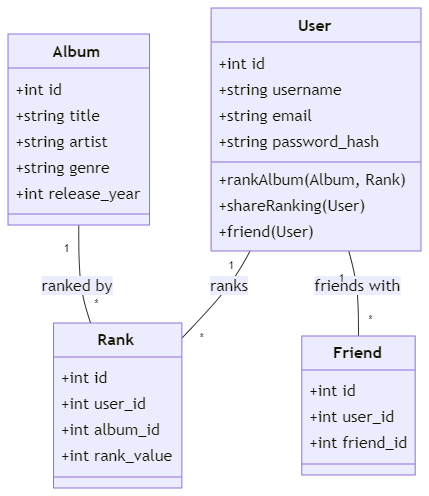

## Data Loss Prevention Policies

When developing a web application like our music ranking app, it's crucial to have measures in place to protect sensitive user data from unauthorized access or accidental loss. This is where data loss prevention (DLP) policies come into play.

Data loss prevention (DLP) refers to the strategies, practices, and tools used to ensure that sensitive data is not lost, misused, or accessed by unauthorized individuals. DLP policies help organizations safeguard their data assets and comply with data protection regulations.

In the context of our music ranking web app, let's explore a few key areas of DLP and how they can be implemented:

1.  **Data encryption** is the process of converting plain text data into a coded format that can only be deciphered with a special key. It helps protect sensitive information from being accessed by unauthorized parties. Example: When a user creates an account on our music ranking app, their password should be encrypted before it is stored in the database. This way, even if someone gains access to the database, they won't be able to see the actual passwords. In our web app, since we are using SQLite as the database, we can leverage Python's built-in encryption libraries to handle data encryption. Python provides modules like `cryptography` or `pycrypto` that offer encryption algorithms and key management functionalities. We can use these libraries to encrypt sensitive data before storing it in the SQLite database and decrypt it when needed.
2.  **Access controls** determine who can access specific data and what actions they can perform on that data. It's important to implement access controls to ensure that users can only access the data they are authorized to see. Example: In our music ranking app, we can implement **role-based access control (RBAC)**. Users with regular accounts should only be able to view and modify their own rankings, while administrators may have additional privileges to manage the overall system. By assigning permissions based on user roles, we can restrict unauthorized access to sensitive data. To implement access controls in our SQLite-based web app, we can leverage Python's web frameworks like Flask or Django. These frameworks provide mechanisms for user authentication and authorization. We can define user roles and assign permissions based on those roles. When a user makes a request to access specific data, the web framework can check their role and permissions to determine whether they are authorized to access the requested data.
3.  **Data backup** involves creating copies of data to prevent loss in case of system failures, accidents, or cyber attacks. Regular data backups ensure that data can be recovered in the event of an incident. Example: Let's say our music ranking app experiences a server crash, and the database becomes corrupted. If we have been regularly backing up the data, we can restore the database from the most recent backup, minimizing data loss and ensuring business continuity. To handle data backup and recovery in our SQLite-based web app, we can utilize Python scripts to automate the backup process. We can schedule regular backups of the SQLite database file and store the backups securely on a separate storage system or in the cloud. In case of a disaster, we can restore the database from the backup file to recover the data.

It's important to note that while SQLite relies on Python and the operating system for certain DLP functionalities, other database management systems like PostgreSQL or MySQL have more native capabilities for data encryption, access controls, and backup/recovery. However, by leveraging Python libraries and following best practices, we can still implement effective DLP measures in our SQLite-based web app.

### Data Classification

When it comes to data governance, classifying data based on its sensitivity and regulatory requirements is a critical step. Data classification helps organizations understand the nature of their data and apply appropriate security measures. In this section, we'll explore common data classification categories and their relevance to our music ranking web app.

1.  **Personally Identifiable Information (PII)** refers to any information that can be used to identify, contact, or locate an individual. Examples of PII include names, email addresses, phone numbers, and social security numbers. In our music ranking app, we may collect PII such as user names, email addresses, and profile pictures. It's essential to handle PII with care and implement appropriate security measures to protect user privacy. This includes encrypting PII in transit and at rest, restricting access to PII based on user roles, and obtaining user consent for data collection and usage.
2.  **Protected Health Information (PHI)** is a subset of PII that relates to an individual's health status, healthcare services, or payment for healthcare services. PHI is protected under specific regulations like the Health Insurance Portability and Accountability Act (HIPAA) in the United States. While our music ranking app may not directly deal with PHI, it's important to be aware of this classification category. If our app were to integrate with healthcare-related services or collect any health-related information, we would need to ensure compliance with HIPAA and implement appropriate safeguards for PHI.
3.  **Payment Card Industry Data Security Standard (PCI-DSS)**  is a set of security standards designed to protect credit card information during transactions and storage. If our music ranking app were to include e-commerce functionalities or process credit card payments, we would need to comply with PCI-DSS requirements. To ensure PCI-DSS compliance, we would need to implement secure payment processing, encrypt credit card data, and follow strict access control measures. This may involve using third-party payment gateways that are PCI-DSS compliant and regularly conducting security assessments.
4.  **Sensitive business data** refers to information that is critical to an organization's operations, intellectual property, or competitive advantage. In the context of our music ranking app, sensitive business data could include algorithms used for ranking calculations, partnership agreements, or financial information. Protecting sensitive business data requires implementing strong access controls, monitoring systems for unauthorized access attempts, and regularly training employees on data handling practices. It's crucial to identify and classify sensitive business data to ensure appropriate security measures are in place.

When developing our music ranking web app, it's important to assess the types of data we will be collecting, processing, and storing. By classifying data based on its sensitivity and regulatory requirements, we can implement targeted security controls and ensure compliance with relevant laws and regulations.

Some best practices for data classification in our web app include:

-   Conducting a data inventory to identify and categorize the types of data we collect.
-   Developing clear data classification policies and guidelines for handling different categories of data.
-   Implementing data access controls based on user roles and the sensitivity of the data.
-   Encrypting sensitive data both in transit and at rest.
-   Regularly training employees and developers on data classification and handling procedures.

By incorporating data classification into our data governance strategy, we can ensure that our music ranking web app handles user data responsibly, maintains compliance, and builds trust with our users.

Global Regulations (GDPR)
-------------------------

In today's interconnected world, web applications often cater to users from different countries and regions. This means that developers need to be aware of and comply with global data protection regulations. One of the most significant regulations in recent years is the General Data Protection Regulation (GDPR) introduced by the European Union (EU).

GDPR is a comprehensive data protection law that came into effect on May 25, 2018. It applies to any organization that collects, processes, or stores personal data of individuals within the EU, regardless of the organization's location. The main objectives of GDPR are to give individuals more control over their personal data and to ensure that organizations handle personal data responsibly and transparently.

Key aspects of GDPR that are relevant to our music ranking web app include:

1.  Data Collection and Consent:
    -   Under GDPR, we must have a legal basis for collecting and processing personal data. In most cases, this means obtaining explicit consent from users.
    -   When users sign up for our music ranking app, we need to provide them with clear information about what data we collect, why we collect it, and how we will use it. Users should have the option to give or withhold consent for different types of data processing.
    -   Consent must be freely given, specific, informed, and unambiguous. It should be as easy for users to withdraw their consent as it is to give it.
2.  Data Rights of Individuals:
    -   GDPR grants individuals certain rights regarding their personal data. These rights include the right to access their data, the right to rectify inaccurate data, the right to erase their data (also known as the "right to be forgotten"), and the right to data portability.
    -   In our music ranking app, we need to provide mechanisms for users to exercise these rights. This may involve implementing features that allow users to view and update their profile information, request data deletion, or export their data in a portable format.
3.  Data Protection by Design and Default:
    -   GDPR requires organizations to implement data protection measures by design and by default. This means that data protection should be considered from the early stages of system development and should be the default setting.
    -   In our web app, we need to incorporate data protection principles into our design and development process. This includes minimizing data collection, using pseudonymization or anonymization techniques where possible, and implementing appropriate security measures to protect user data.
4.  Data Breach Notification:
    -   GDPR requires organizations to notify the relevant supervisory authority and affected individuals in case of a data breach that poses a risk to individuals' rights and freedoms.
    -   In our music ranking app, we need to have mechanisms in place to detect and respond to data breaches promptly. This may involve implementing monitoring and alerting systems, having an incident response plan, and establishing clear communication channels with users and authorities.

To ensure compliance with GDPR, it's essential to conduct a thorough assessment of our web app's data processing activities, develop comprehensive privacy policies, and implement appropriate technical and organizational measures to protect user data.

It's important to note that GDPR is just one example of global data protection regulations. Other regions may have their own specific regulations, such as the California Consumer Privacy Act (CCPA) in the United States or the Personal Information Protection Law (PIPL) in China. As developers, it's crucial to stay informed about the relevant regulations in the regions where our web app operates and ensure compliance accordingly.

### Discussion Questions

1.  Why is data governance important for web applications like the music ranking app? What are the potential consequences of neglecting data governance?
2.  How can encryption, access controls, and data backups help prevent data loss and unauthorized access in the music ranking app? What are some specific examples of implementing these measures?
3.  Imagine the music ranking app expands to include a feature that allows users to purchase concert tickets. What additional data classification considerations would come into play, and how would you address them?
4.  As a developer working on the music ranking app, how would you ensure compliance with GDPR? What specific steps would you take to obtain user consent, protect user rights, and implement data protection by design and default?
5.  In the event of a data breach in the music ranking app, what actions would you take to mitigate the impact and comply with GDPR's breach notification requirements?
6.  How can you stay informed about the latest data protection regulations and ensure that the music ranking app remains compliant as it grows and expands to new regions?
7.  Beyond technical measures, what organizational policies and employee training initiatives would you recommend to foster a culture of data privacy and security within the development team?

## Chapter Summary Points

-   Views are virtual tables that simplify complex queries and provide a user-friendly interface for data retrieval
-   Views enable data aggregation, access control, and enhance data security
-   SQLite supports three types of views: default views, temporary views, and materialized views (simulated)
-   Common Table Expressions (CTEs) are temporary named result sets within a single SQL statement
-   CTEs break down complex queries into manageable parts, improving code readability and maintainability
-   Views and CTEs can be used together to create powerful and efficient database solutions
-   Data governance, including data loss prevention and compliance with regulations like GDPR, is crucial for web applications handling sensitive user data
-   Implementing data governance requires a holistic approach involving technical measures, organizational policies, and employee training

## Lab: Practice Your SQL

In [27]:
!wget https://github.com/brendanpshea/colab-utilities/raw/main/sql_select_quiz.py -q -nc
from sql_select_quiz import *

sql_select_quiz_from_id("music")

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (sql_select_quiz.py, line 296)

## Review With Quizlet

In [ ]:
%%html
<iframe src="https://quizlet.com/930415532/learn/embed?i=psvlh&x=1jj1" height="600" width="100%" style="border:0"></iframe>

## Glossary
| Term | Definition |
| --- | --- |
| Common Table Expression (CTE) | A temporary result set that you can reference within a SELECT, INSERT, UPDATE, or DELETE statement. It is defined using the WITH keyword. |
| CREATE v AS VIEW as query | A SQL statement that creates a virtual table named 'v' based on the result set of a query. |
| Data classification | The process of organizing data into categories based on its sensitivity, value, or other criteria to ensure it is handled appropriately. |
| Data dictionary | A set of metadata that describes the structure, content, and constraints of a database. |
| Data Governance | The overall management of the availability, usability, integrity, and security of the data employed in an enterprise. |
| Data Loss Prevention | A strategy for ensuring that end users do not send sensitive or critical information outside the corporate network. |
| Distributed database | A database in which storage devices are not all attached to a common CPU. It may be stored in multiple computers, located in the same physical location, or dispersed over a network of interconnected computers. |
| DROP VIEW IF EXISTS view_name | A SQL statement that deletes the view named 'view_name' if it exists. |
| Encryption | The process of converting data into a form that cannot be easily understood by unauthorized parties. |
| GDPR | The General Data Protection Regulation, a European Union law on data protection and privacy that addresses the transfer of personal data outside the EU and EEA areas. |
| Globally unique identifier (GUID) | A 128-bit integer used to uniquely identify information in computer systems. |
| Informed Consent | Permission granted with the knowledge of the possible consequences. |
| MATERIALIZED VIEW | A database object that contains the results of a query. Unlike a standard view, a materialized view is stored on disk and can be refreshed periodically. |
| PCI-DSS | The Payment Card Industry Data Security Standard, a set of security standards designed to ensure that all companies that accept, process, store, or transmit credit card information maintain a secure environment. |
| Personal Health Information (PHI) | Any information about the health status, provision of health care, or payment for health care that can be linked to a specific individual. |
| Personally Identifiable Information (PII) | Any data that could potentially be used to identify a particular person. |
| Right to be forgotten | A right under the GDPR that allows individuals to have their personal data erased under certain circumstances. |
| Right to data breach notification | A right under the GDPR that requires organizations to notify individuals if there has been a breach of their personal data. |
| Right to rectify | A right under the GDPR that allows individuals to have inaccurate personal data corrected. |
| Role-based access controls (RBAC) | A method of restricting system access to authorized users based on their role within an organization. |
| TEMPORARY VIEW | A view that exists only for the duration of a session or transaction. |
| VIEW (default) | A virtual table that is based on the result set of a query. A default view is not materialized and is not temporary. |
| WITH cte_name AS (inner_query) outer_query | A SQL syntax that defines a Common Table Expression (CTE) named 'cte_name' using the result set of 'inner_query', which can then be used in 'outer_query'. |